In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp
import torch_geometric.nn
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops


/Applications/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Applications/anaconda3/lib/python3.11/site-packages/torch_sparse/_convert_cpu.so, 0x0006): symbol not found in flat namespace '__ZN2at8internal15invoke_parallelExxxRKNSt3__18functionIFvxxEEE'
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [7]:
node_features = pd.read_csv('preprocessed_node_features.csv')

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_2106/3506719987.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,25

In [8]:
edge_features = pd.read_csv('preprocessed_edge_features.csv')

Node classification accuracy: Predicting the label of each node

In [9]:
node_features_numeric = node_features.select_dtypes(include=['number', 'bool'])  # Include numeric and boolean columns

if 'root_id' in node_features_numeric.columns:
    node_features_numeric = node_features_numeric.drop(columns=['root_id'])



In [10]:
node_features_tensor = torch.tensor(node_features_numeric.values, dtype=torch.float)

In [11]:
id_to_index = {root_id: idx for idx, root_id in enumerate(node_features['root_id'])} # PyTorch Geometric GNN works with nodes referenced by integer indices not arbitrary IDs

edge_features['pre_root_id'] = edge_features['pre_root_id'].map(id_to_index)
edge_features['post_root_id'] = edge_features['post_root_id'].map(id_to_index)

# Remove rows with unmapped IDs
edge_features = edge_features.dropna(subset=['pre_root_id', 'post_root_id']).astype({'pre_root_id': int, 'post_root_id': int})

edge_index = torch.tensor(edge_features[['pre_root_id', 'post_root_id']].values.T, dtype=torch.long) # standard edge representation used in PyTorch Geometric


In [12]:
labels = torch.tensor(node_features['nt_type'].factorize()[0], dtype=torch.long)

In [13]:
data = Data(
    x=node_features_tensor,
    edge_index=edge_index
)

In [14]:
data.y = torch.tensor(labels, dtype=torch.long) # true labels

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_2106/2186120499.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(labels, dtype=torch.long) # true labels


simple GNN

In [47]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [48]:
loader = DataLoader([data], batch_size=1, shuffle=True)

model = GNN(input_dim=node_features_tensor.size(1), hidden_dim=64, output_dim=len(labels.unique()))
optimizer = Adam(model.parameters(), lr=0.001) # try smaller lr 0.001, default adam optimizer loss. 
# play around with parameters
loss_fn = nn.CrossEntropyLoss()

loss_values = []

for epoch in range(100):
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 121.50762176513672
Epoch 2, Loss: 111.38530731201172
Epoch 3, Loss: 101.33079528808594
Epoch 4, Loss: 92.35541534423828
Epoch 5, Loss: 84.7454605102539
Epoch 6, Loss: 77.41429901123047
Epoch 7, Loss: 69.8852767944336
Epoch 8, Loss: 62.08249282836914
Epoch 9, Loss: 54.39713668823242
Epoch 10, Loss: 47.307762145996094
Epoch 11, Loss: 40.85969543457031
Epoch 12, Loss: 34.85842514038086
Epoch 13, Loss: 29.01502227783203
Epoch 14, Loss: 25.155920028686523
Epoch 15, Loss: 23.86476707458496
Epoch 16, Loss: 23.41486358642578
Epoch 17, Loss: 23.220441818237305
Epoch 18, Loss: 23.07525634765625
Epoch 19, Loss: 22.847536087036133
Epoch 20, Loss: 22.468061447143555
Epoch 21, Loss: 21.921607971191406
Epoch 22, Loss: 21.206775665283203
Epoch 23, Loss: 20.26052474975586
Epoch 24, Loss: 19.136693954467773
Epoch 25, Loss: 17.866724014282227
Epoch 26, Loss: 16.469470977783203
Epoch 27, Loss: 14.971861839294434
Epoch 28, Loss: 13.544379234313965
Epoch 29, Loss: 12.69909954071045
Epoch 30, 

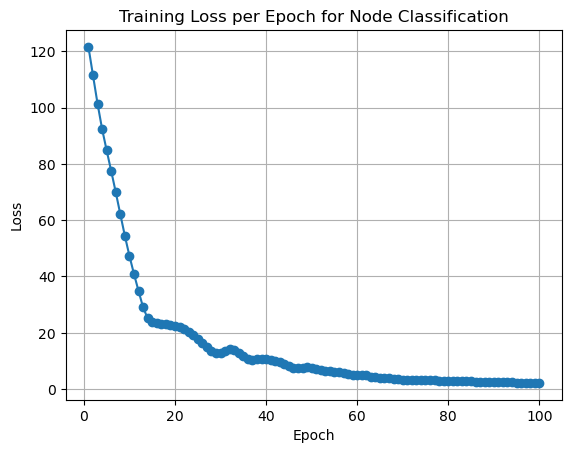

In [49]:
import matplotlib.pyplot as plt

plt.plot(range(1, 101), loss_values, marker='o')
plt.title("Training Loss per Epoch for Node Classification")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [50]:
from sklearn.metrics import accuracy_score

model.eval()
correct = 0
total = 0

for batch in loader:
    out = model(batch) 
    predictions = out.argmax(dim=1)

    # Count correct predictions
    correct += (predictions == batch.y).sum().item()
    total += batch.y.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5094


In [51]:
train_mask = torch.rand(len(data.y)) < 0.8  # 80% for training
val_mask = ~train_mask  # Remaining 20% for validation

# Training loader
train_loader = DataLoader([data], batch_size=1, shuffle=True)

# Model, optimizer, and loss
model = GNN(input_dim=node_features_tensor.size(1), hidden_dim=64, output_dim=len(labels.unique()))
optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

/Applications/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [52]:
# Track metrics
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(100):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out[train_mask], batch.y[train_mask])  # Use train_mask
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = loss_fn(out[val_mask], data.y[val_mask])  # Use val_mask
        val_losses.append(val_loss.item())

        # Compute validation accuracy
        val_preds = out[val_mask].argmax(dim=1)
        val_acc = accuracy_score(data.y[val_mask].cpu(), val_preds.cpu())
        val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1, Train Loss: 34.5263, Val Loss: 48.7200, Val Acc: 0.1459
Epoch 2, Train Loss: 48.7996, Val Loss: 39.8895, Val Acc: 0.1297
Epoch 3, Train Loss: 39.7186, Val Loss: 14.3563, Val Acc: 0.1855
Epoch 4, Train Loss: 14.1985, Val Loss: 20.8043, Val Acc: 0.4426
Epoch 5, Train Loss: 20.1934, Val Loss: 27.8520, Val Acc: 0.6213
Epoch 6, Train Loss: 26.8840, Val Loss: 29.9409, Val Acc: 0.6145
Epoch 7, Train Loss: 28.8325, Val Loss: 27.2334, Val Acc: 0.5639
Epoch 8, Train Loss: 26.2111, Val Loss: 20.1905, Val Acc: 0.5734
Epoch 9, Train Loss: 19.4025, Val Loss: 19.4250, Val Acc: 0.1507
Epoch 10, Train Loss: 18.9303, Val Loss: 13.8893, Val Acc: 0.1540
Epoch 11, Train Loss: 13.5057, Val Loss: 12.8693, Val Acc: 0.5825
Epoch 12, Train Loss: 12.3453, Val Loss: 14.3119, Val Acc: 0.5006
Epoch 13, Train Loss: 13.7870, Val Loss: 17.5495, Val Acc: 0.3432
Epoch 14, Train Loss: 17.1113, Val Loss: 17.2235, Val Acc: 0.3804
Epoch 15, Train Loss: 16.7132, Val Loss: 16.6195, Val Acc: 0.5650
Epoch 16, Train Los

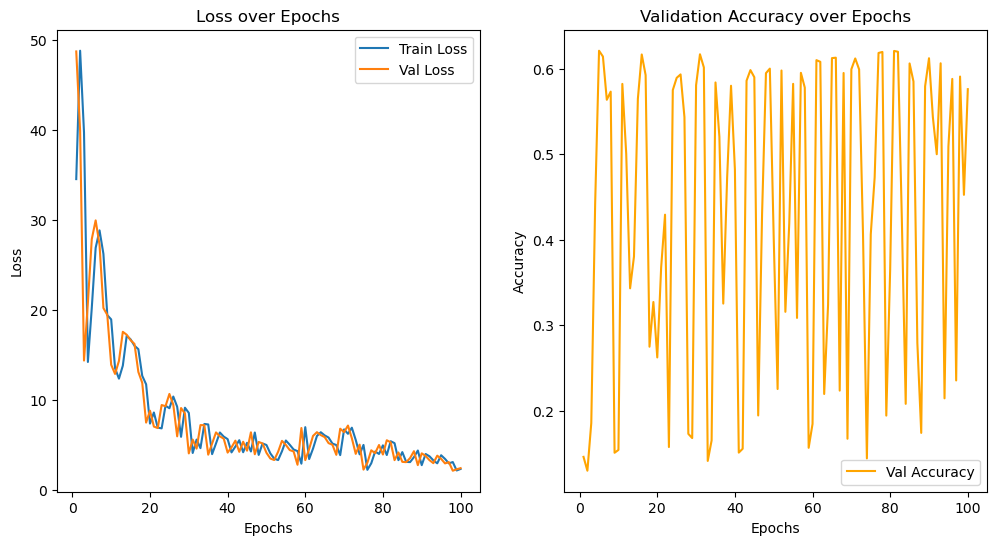

In [53]:
# Plot training/validation losses and validation accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()

more complicated our own made brainGNN

In [15]:
from sklearn.model_selection import train_test_split

indices = torch.arange(len(labels)) 
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_indices] = True
val_mask[val_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask

val_data = data

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from torch_geometric.data import DataLoader
from torch.optim import Adam

class AdvancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdvancedGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.conv4 = GCNConv(hidden_dim, output_dim) 
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = self.conv3(x, edge_index)
        x = F.relu(self.bn3(x))
        x = self.dropout(x) 
        x = self.conv4(x, edge_index)
        
        return x
# class AdvancedGNN(torch.nn.Module):
#     def __init__(self, indim, ratio, nclass, k=8, R=200):
#         super(AdvancedGNN, self).__init__()

#         self.indim = indim
#         self.dim1 = 32
#         self.dim2 = 32
#         self.dim3 = 512
#         self.dim4 = 256
#         self.dim5 = 8
#         self.k = k
#         self.R = R

#         self.conv1 = GCNConv(self.indim, self.dim1)
#         self.pool1 = TopKPooling(self.dim1, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)

#         self.conv2 = GCNConv(self.dim1, self.dim2)
#         self.pool2 = TopKPooling(self.dim2, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)

#         self.fc1 = torch.nn.Linear((self.dim1 + self.dim2) * 2, self.dim2)
#         self.ln1 = torch.nn.LayerNorm(self.dim2)
#         self.fc2 = torch.nn.Linear(self.dim2, self.dim3)
#         self.ln2 = torch.nn.LayerNorm(self.dim3)
#         self.fc3 = torch.nn.Linear(self.dim3, nclass)

#     def forward(self, x, edge_index, batch):
#         # First GCNConv + pooling
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x, edge_index, _, batch, perm, score1 = self.pool1(x, edge_index, None, batch)

#         x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

#         # Second GCNConv + pooling
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         x, edge_index, _, batch, perm, score2 = self.pool2(x, edge_index, None, batch)

#         x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

#         # Combine outputs from both layers
#         x = torch.cat([x1, x2], dim=1)
#         x = self.ln1(F.relu(self.fc1(x)))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.ln2(F.relu(self.fc2(x)))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = F.log_softmax(self.fc3(x), dim=-1)

#         return x

In [17]:
val_loader = DataLoader([val_data], batch_size=32, shuffle=False)  # Validation data

train_mask = torch.rand(len(data.y)) < 0.8  # 80% for training
val_mask = ~train_mask  # Remaining 20% for validation

# Training loader
train_loader = DataLoader([data], batch_size=1, shuffle=True)

# Model setup
model = AdvancedGNN(
    input_dim=node_features_tensor.size(1),
    hidden_dim=64,
    output_dim=len(labels.unique())
)
optimizer = Adam(model.parameters(), lr=0.001) 
loss_fn = nn.CrossEntropyLoss()

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(100):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch) 

        loss = loss_fn(out[train_mask], batch.y[train_mask])
        
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = loss_fn(out[val_mask], data.y[val_mask])  # Use val_mask
        val_losses.append(val_loss.item())

        val_preds = out[val_mask].argmax(dim=1)
        val_acc = accuracy_score(data.y[val_mask].cpu(), val_preds.cpu())
        val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {val_losses[-1]:.4f}, Test Acc: {val_acc:.4f}")


/Applications/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 2.3152, Test Loss: 2.0985, Test Acc: 0.1574
Epoch 2, Train Loss: 2.1856, Test Loss: 1.9780, Test Acc: 0.1709
Epoch 3, Train Loss: 2.0867, Test Loss: 1.9559, Test Acc: 0.1869
Epoch 4, Train Loss: 2.0122, Test Loss: 1.9539, Test Acc: 0.1913
Epoch 5, Train Loss: 1.9223, Test Loss: 1.9559, Test Acc: 0.1903
Epoch 6, Train Loss: 1.8966, Test Loss: 1.9540, Test Acc: 0.1899
Epoch 7, Train Loss: 1.8308, Test Loss: 1.9501, Test Acc: 0.1896
Epoch 8, Train Loss: 1.7962, Test Loss: 1.9400, Test Acc: 0.1862
Epoch 9, Train Loss: 1.7787, Test Loss: 1.9265, Test Acc: 0.2204
Epoch 10, Train Loss: 1.7341, Test Loss: 1.9108, Test Acc: 0.2270
Epoch 11, Train Loss: 1.6795, Test Loss: 1.8958, Test Acc: 0.2332
Epoch 12, Train Loss: 1.6570, Test Loss: 1.8794, Test Acc: 0.2416
Epoch 13, Train Loss: 1.6170, Test Loss: 1.8621, Test Acc: 0.2528
Epoch 14, Train Loss: 1.6023, Test Loss: 1.8431, Test Acc: 0.2693
Epoch 15, Train Loss: 1.5793, Test Loss: 1.8223, Test Acc: 0.2926
Epoch 16, Train Los

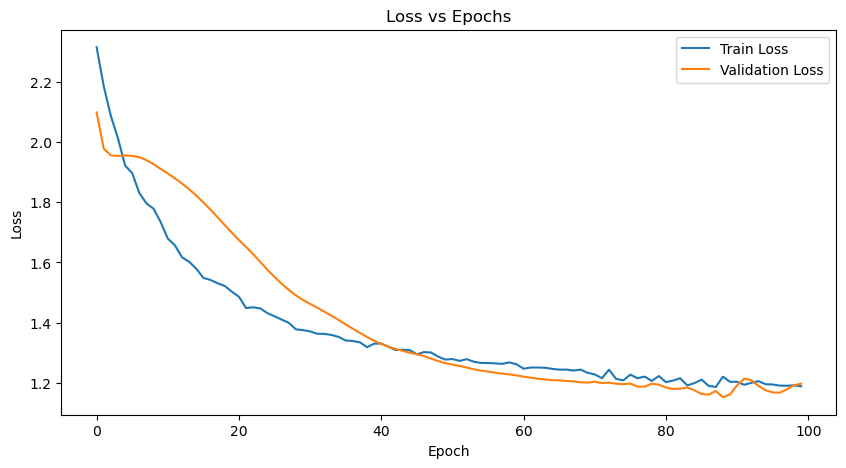

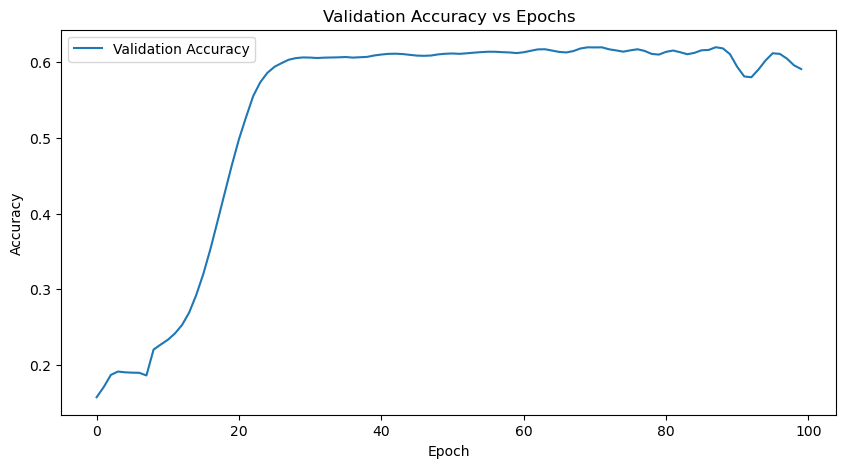

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Epochs')
plt.show()


try some other simpler task. ex. number of edges, maybe edge classification. connectivity tag

try training on half that data and see if get same accuracy. try increasing network. 

some other papers that are brain network related. say their accuracy is 65%. compare our accuracy vs theirs

look at another task. bc not worth it to try to refine it. 

try to justify why it's not learning. 

number of edges

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error

# Define the AdvancedGNN for graph-level regression
class EdgePredictorGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EdgePredictorGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, 1)  # Single output for edge count regression

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GNN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        # Fully connected layer for regression
        x = self.fc(x)
        return x


In [24]:
print(f"Node features shape: {data.x.shape}")


Node features shape: torch.Size([139246, 6])


In [25]:
print(f"Edge index shape: {data.edge_index.shape}")


Edge index shape: torch.Size([2, 3869628])


In [31]:
print(f"Edge counts in training data: {data.edge_count}")


Edge counts in training data: tensor([3869628.])


In [32]:
data.edge_count = torch.tensor([data.edge_index.size(1)], dtype=torch.float)  # Example target

data.edge_count = data.edge_count / data.edge_count.max()  # Normalize between 0 and 1


# DataLoader (adjust as per your data)
train_loader = DataLoader([data], batch_size=1, shuffle=True)
val_loader = DataLoader([data], batch_size=1, shuffle=False)

# Model setup
input_dim = data.x.shape[1]  # Should be 6
hidden_dim = 64  # Example hidden dimension

model = EdgePredictorGNN(input_dim=input_dim, hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        out = model(batch)  # Output is graph-level

        # Compute loss (regression target is edge_count)
        loss = loss_fn(out.squeeze(), batch.edge_count.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            val_loss = loss_fn(out.squeeze(), batch.edge_count.squeeze())
            epoch_val_loss += val_loss.item()
            predictions.append(out.item())
            targets.append(batch.edge_count.item())
        
        

    val_losses.append(val_loss / len(val_loader))
    mse = mean_squared_error(targets, predictions)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, MSE: {mse:.4f}")

# Test performance (optional)
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for batch in val_loader:
        out = model(batch)
        predictions.append(out.item())
        targets.append(batch.edge_count.item())

    mse = mean_squared_error(targets, predictions)
    print(f"Mean Squared Error on Validation Data: {mse:.4f}")


Epoch 1, Train Loss: 117.4219, Val Loss: 0.0046, MSE: 0.0046
Epoch 2, Train Loss: 0.0046, Val Loss: 51.7922, MSE: 51.7922
Epoch 3, Train Loss: 51.7922, Val Loss: 61.5241, MSE: 61.5241
Epoch 4, Train Loss: 61.5241, Val Loss: 25.9482, MSE: 25.9482
Epoch 5, Train Loss: 25.9482, Val Loss: 1.2922, MSE: 1.2922
Epoch 6, Train Loss: 1.2922, Val Loss: 6.4906, MSE: 6.4906
Epoch 7, Train Loss: 6.4906, Val Loss: 23.4853, MSE: 23.4853
Epoch 8, Train Loss: 23.4853, Val Loss: 28.9704, MSE: 28.9704
Epoch 9, Train Loss: 28.9704, Val Loss: 19.5463, MSE: 19.5463
Epoch 10, Train Loss: 19.5463, Val Loss: 6.1626, MSE: 6.1626
Epoch 11, Train Loss: 6.1626, Val Loss: 0.0230, MSE: 0.0230
Epoch 12, Train Loss: 0.0230, Val Loss: 3.9101, MSE: 3.9101
Epoch 13, Train Loss: 3.9101, Val Loss: 11.5201, MSE: 11.5201
Epoch 14, Train Loss: 11.5201, Val Loss: 14.6249, MSE: 14.6249
Epoch 15, Train Loss: 14.6249, Val Loss: 10.8245, MSE: 10.8245
Epoch 16, Train Loss: 10.8245, Val Loss: 4.1583, MSE: 4.1583
Epoch 17, Train Loss

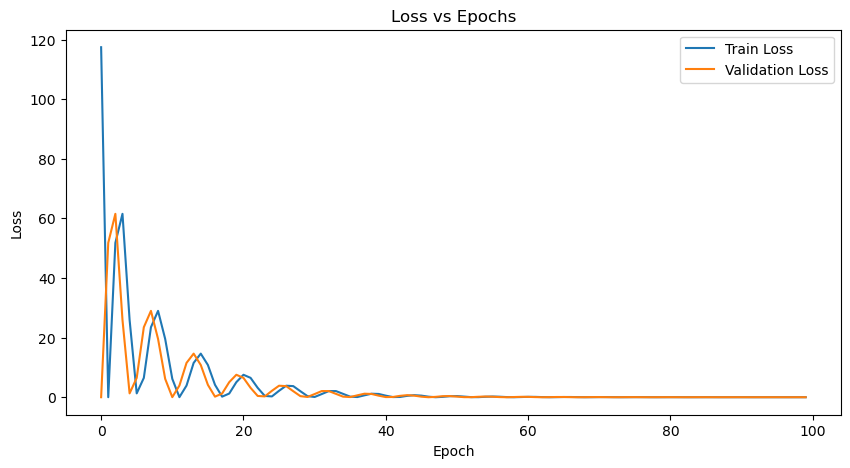

In [35]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# # Plot validation accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Validation Accuracy vs Epochs')
# plt.show()
